In [1]:
# !pip install numpy==1.26.0
# !pip install torch==2.2.0
# !pip install torchquantum
# !pip install qiskit==0.43.1 qiskit-terra==0.24.1 qiskit-aer==0.12.0 qiskit-ibm-provider==0.6.1 qiskit-ibm-runtime==0.10.0


# !pip install openvino
# !pip install onnxruntime
# !pip install onnx
# !pip install imageio
# !pip install habana-torch


In [2]:
import numpy as np
import pandas as pd
import time
import cv2
import torch
import torchvision
from torchvision import utils as vutils
from torchvision import transforms
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torch.optim import SGD, Adam
from PIL import Image
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import os
import onnx
from statistics import mean
# import pennylane as qml
import torchquantum as tq


In [3]:
# !pip install torch==2.2.0
# !pip install --user habana-torch


In [4]:
#Global Variables

In [5]:
# Device
import torch

# Set device to CPU as default since Habana Gaudi is not used
device = torch.device("cpu")
print('Experiments running on: {}'.format(device))

# Hyperparameters
random_seed = 1
learning_rate = 0.001
num_epochs = 1

# Architecture
root_dir = './models'

Experiments running on: cpu


In [6]:
!pip install kagglehub
# !pip install pandas 



Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mateuszbuda/lgg-mri-segmentation")

print("Path to dataset files:", path)

Path to dataset files: /home/u08848f356fb016cae0e984c1d966b25/.cache/kagglehub/datasets/mateuszbuda/lgg-mri-segmentation/versions/2


In [8]:
import os
'''
Extract number of positive vs negative samples (where negative samples have an all-zero mask)
Check for files without corresponding mask and vice versa
'''
# root = './dataset/archive/lgg-mri-segmentation/kaggle_3m'
root = '/home/u08848f356fb016cae0e984c1d966b25/.cache/kagglehub/datasets/mateuszbuda/lgg-mri-segmentation/versions/2/kaggle_3m'

no_mask = 0
no_mask_files = []
no_file = 0
no_files = []
num_empty_masks = 0
num_nonempty_masks = 0

S = 3 # number of pos/neg samples to take
empty_mask_samples = []
nonempty_mask_samples = []

img_dimensions = []
msk_dimensions = []

n_files = 0
for directory in [os.path.join(root,x) for x in os.listdir(root) if os.path.isdir(os.path.join(root, x))]:
    for file in os.listdir(directory):
        n_files += 1
        img_dimensions.append(np.array(cv2.imread(os.path.join(directory, file))).shape)
        #count files with no mask
        if 'mask' not in file:
            #check if mask exists
            mask_path = os.path.join(directory, file[:file.find('.tif')]+'_mask.tif')
            if not os.path.exists(mask_path):
                no_mask += 1
                no_mask_files.append(os.path.join(directory, file))
        else:
            msk_dimensions.append(np.array(cv2.imread(os.path.join(directory, file), cv2.IMREAD_UNCHANGED)).shape)
            #count masks with no file
            f_path = os.path.join(directory, file[:file.find('mask')-1]+'.tif')
            #check if file exists
            if not os.path.exists(f_path):
                no_file += 1
                no_files.append(os.path.join(directory, file))

            #check if mask is empty
            j = np.max(cv2.imread(os.path.join(directory, file), cv2.IMREAD_UNCHANGED))
            if j > 0:
                num_nonempty_masks += 1
                if len(nonempty_mask_samples) < S:
                    nonempty_mask_samples.append(os.path.join(directory, file))
            else:
                num_empty_masks += 1
                if len(empty_mask_samples) < S:
                    empty_mask_samples.append(os.path.join(directory, file))


In [9]:
#check variance in dimensions
print('Image Dimensions')
print(len(set(img_dimensions)))
print(set(img_dimensions))
print('Mask Dimensions')
print(len(set(msk_dimensions)))
print(set(msk_dimensions))

Image Dimensions
1
{(256, 256, 3)}
Mask Dimensions
1
{(256, 256)}


#No Mask: 0
#Mask w/ No File: 0
#Total Files 7858


<BarContainer object of 2 artists>

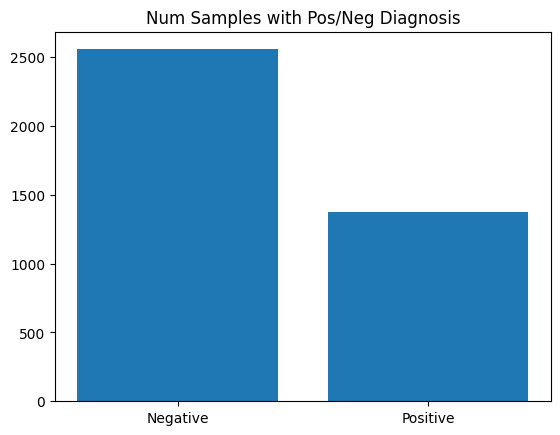

In [10]:
print(f'#No Mask: {no_mask}')
print(f'#Mask w/ No File: {no_file}')
print(f'#Total Files {n_files}')

plt.figure()
plt.title('Num Samples with Pos/Neg Diagnosis')
plt.bar([0,1], [num_empty_masks, num_nonempty_masks], tick_label=['Negative', 'Positive'])

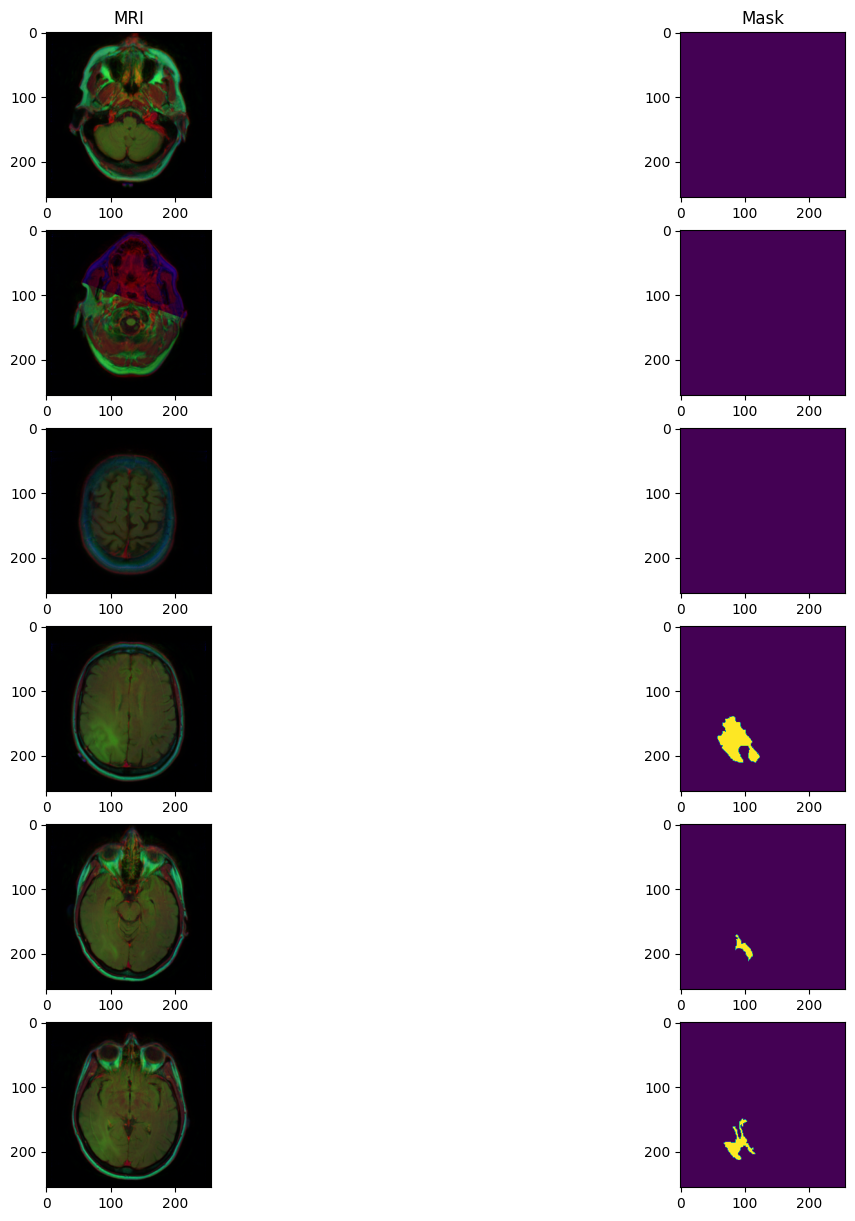

In [11]:
#display images of negative and positive samples - negative samples have an empty mask
fig, axs = plt.subplots(6,2, figsize=(15,15))
for ax, col in zip(axs[0], ['MRI', 'Mask']):
    ax.set_title(col)

display_imgs = empty_mask_samples+nonempty_mask_samples #concat lists for easy plotting
#print(display_imgs)
for i in range(len(display_imgs)):
    mask_path = display_imgs[i]
    img_path = mask_path[:mask_path.find('mask')-1]+'.tif'
    axs[i,0].imshow(np.array(cv2.imread(img_path)))
    axs[i,1].imshow(np.array(cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)))

In [12]:
#Create Torch Dataset
#segmentation 

In [13]:
class Brain_MRI_Segmentation_Dataset(data.Dataset):
    def __init__(self, inputs, transform=None):
        self.inputs = inputs
        self.transform = transform
        self.input_dtype = torch.float32
        self.target_dtype = torch.float32

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        #for classification return only the image and the binary label
        img_path = self.inputs[index][0]
        mask_path = self.inputs[index][1]
        #mask_img = cv2.normalize(cv2.imread(mask_path), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        mask_img = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        x = torch.from_numpy(np.transpose(np.array(cv2.imread(img_path)), (2,0,1))).type(self.input_dtype)
        y = torch.from_numpy(np.resize(np.array(mask_img)/255., (1,256,256))).type(self.target_dtype)

        if self.transform is not None:
            x = self.transform(x)
            y = self.transform(y)

        return x,y


In [14]:
file_list = []

for directory in [os.path.join(root, x) for x in os.listdir(root) if os.path.isdir(os.path.join(root, x))]:
    for file in os.listdir(directory):
        # Add files to the list
        if 'mask' not in file:
            result = 0
            img_path = os.path.join(directory, file)
            mask_path = os.path.join(directory, file[:file.find('.tif')]+'_mask.tif')

            # Attempt to read the mask image
            mask_img = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

            # Check if the image is successfully loaded
            if mask_img is not None and np.max(mask_img) > 0:
                result = 1


                file_list.append([img_path, mask_path, result])



In [15]:
#load data
positive_diagnoses = [x for x in file_list if x[2] == 1]
# print(positive_diagnoses[:5])
mri_dataset = Brain_MRI_Segmentation_Dataset(positive_diagnoses)

validation_size = int(0.2 * len(mri_dataset))
test_size = int(0.1 * len(mri_dataset))

train_set, val_set, test_set = data.random_split(mri_dataset, [len(mri_dataset)-(validation_size+test_size), validation_size, test_size])

train_loader = data.DataLoader(dataset=train_set, batch_size=8, shuffle=True, num_workers=2)
val_loader = data.DataLoader(dataset=val_set, batch_size=8, shuffle=False, num_workers=2)
test_loader = data.DataLoader(dataset=test_set, batch_size=8, shuffle=False, num_workers=2)


In [16]:
#losses
#dices lose

In [17]:
#Dice Loss Function - taken from: https://github.com/kevinzakka/pytorch-goodies/blob/master/losses.py
def dice_loss(logits, true, eps=1e-7):
    """Computes the Sørensen–Dice loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the dice loss so we
    return the negated dice loss.
    Args:
        true: a tensor of shape [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        dice_loss: the Sørensen–Dice loss.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1, device= device)[true.long().squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.long().squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)


In [18]:
#combined cross entropy and dice loss
def bce_dice_loss(output, target):
    bce = nn.BCEWithLogitsLoss()
    return bce(output, target) + dice_loss(output, target)


In [19]:
#Cross entropy loss used in class
def Cross_loss(output, target):
    loss_func = torch.nn.CrossEntropyLoss()
    return loss_func(output, target)


In [20]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor, threshold=0.5):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    SMOOTH = 1e-6
    # outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    # labels = labels.squeeze(1)

    bin_out = torch.where(outputs > threshold, 1, 0).type(torch.int16)
    labels = labels.type(torch.int16)

    intersection = (bin_out & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (bin_out | labels).float().sum((1, 2))         # Will be zero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our division to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded.mean()  # Or thresholded.mean() if you are interested in average across the batch


In [21]:
#models
#classcial Segnet 

In [22]:

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.sequence = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

    def forward(self, x):
        return self.sequence(x)

class Decoder(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(Decoder, self).__init__()
        combined_channels = in_channels + skip_channels
        self.sequence = nn.Sequential(
            nn.Conv2d(combined_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(out_channels, out_channels, kernel_size=2, stride=2),
        )

    def forward(self, x):
        return self.sequence(x)

class Segnet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Segnet, self).__init__()

        # Reduced Encoder Layers
        self.encoder1 = Encoder(in_channels, 16)
        self.encoder2 = Encoder(16, 32)
        self.encoder3 = Encoder(32, 64)

        # Reduced Decoder Layers
        self.decoder1 = Decoder(64, 0, 32)
        self.decoder2 = Decoder(32, 32, 16)
        self.decoder3 = Decoder(16, 16, out_channels)   # Changed the final decoder layer

        # Final Output Convolution
        self.output_conv = nn.Conv2d(out_channels, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoding
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)

        # Decoding
        d1 = self.decoder1(e3)
        d2 = self.decoder2(torch.cat([d1, e2], dim=1))
        d3 = self.decoder3(torch.cat([d2, e1], dim=1))

        # Output
        logits = self.output_conv(d3)

        return logits


In [23]:
modelSegnet = Segnet(in_channels=3, out_channels=1)


In [24]:
# No need to clear GPU cache, as we're using CPU
modelSegnet.to(device)

# Optionally print the model architecture
# print(modelSegnet)

Segnet(
  (encoder1): Encoder(
    (sequence): Sequential(
      (0): ConvBlock(
        (block): Sequential(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (encoder2): Encoder(
    (sequence): Sequential(
      (0): ConvBlock(
        (block): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
         

In [25]:
num_params = sum(p.numel() for p in modelSegnet.parameters() if p.requires_grad)
print(num_params)

117238


In [26]:
#Quantum Classical Model

In [27]:
import torch
import torch.nn.functional as F
import torchquantum as tq

# 10% patches

class QuanvolutionFilter(tq.QuantumModule):
    def __init__(self, patch_size=2):
        super().__init__()
        self.n_wires = 4
        self.q_device = tq.QuantumDevice(n_wires=self.n_wires)
        self.encoder = tq.GeneralEncoder(
            [{'input_idx': [i], 'func': 'rx', 'wires': [i]} for i in range(self.n_wires)]
        )
        self.q_layer = tq.RandomLayer(n_ops=1, wires=list(range(self.n_wires)))
        self.measure = tq.MeasureAll(tq.PauliZ)
        self.patch_size = patch_size

    def forward(self, x):
        bsz, channels, height, width = x.size()
        device = x.device
        self.q_device.reset_states(bsz=bsz)
    
        # Unfold the input tensor to extract patches
        x_unfold = F.unfold(x, kernel_size=self.patch_size, stride=self.patch_size)
        patches = x_unfold.transpose(1, 2).reshape(bsz, -1, channels, self.patch_size**2).to(device)
        # print(f"patches shape: {patches.shape}")
    
        # Define mask for conditional processing (only 10% of patches)
        num_patches = patches.size(1)
        quantum_mask = torch.zeros(num_patches, dtype=torch.bool, device=device)
        quantum_mask[::10] = True  # Select every 10th patch
    
        quantum_patches = patches[:, quantum_mask, :, :]  # Patches for quantum processing
        # print(f"quantum patches shape: {quantum_patches.shape}")
    
        # Process quantum patches in smaller batches
        quantum_patches_flat = quantum_patches.view(-1, self.n_wires)
        
        # Apply quantum encoding to quantum patches in smaller chunks
        # chunk_size = min(quantum_patches_flat.size(0), bsz)  # Adjust chunk size as needed
        chunk_size = bsz
        quantum_processed_chunks = []
        for i in range(0, quantum_patches_flat.size(0), chunk_size):
            chunk = quantum_patches_flat[i:i + chunk_size]
            self.encoder(self.q_device, chunk)
            quantum_processed_chunks.append(self.measure(self.q_device))
        
        # Concatenate processed chunks and reshape to match original patch layout
        quantum_processed = torch.cat(quantum_processed_chunks, dim=0).view(bsz, -1, channels, self.patch_size**2)
    
        # Reconstruct the patches by placing quantum and non-quantum patches back in their positions
        processed_patches = patches.clone()
        processed_patches[:, quantum_mask, :, :] = quantum_processed  # Insert processed patches
    
        # Prepare for folding
        processed_patches = processed_patches.permute(0, 2, 3, 1).reshape(bsz, -1, patches.size(1))
        recombined = F.fold(processed_patches, output_size=(height, width), kernel_size=self.patch_size, stride=self.patch_size)
    
        return recombined



# Quantum Layer Wrapper
class QuantumLayer(nn.Module):
    def __init__(self):
        super(QuantumLayer, self).__init__()
        self.quanv_filter = QuanvolutionFilter()
    
    def forward(self, x):
        return self.quanv_filter(x)

# Convolutional Block (remains the same)
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

# Encoder, Decoder, and SegnetQuantum Definition (with QuantumLayer integrated)
class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.sequence = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

    def forward(self, x):
        return self.sequence(x)

class Decoder(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(Decoder, self).__init__()
        combined_channels = in_channels + skip_channels
        self.sequence = nn.Sequential(
            nn.Conv2d(combined_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(out_channels, out_channels, kernel_size=2, stride=2),
        )

    def forward(self, x):
        return self.sequence(x)

class SegnetQuantum(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SegnetQuantum, self).__init__()

        # Encoder Layers
        self.encoder1 = Encoder(in_channels, 64)
        self.encoder2 = Encoder(64, 128)
        self.encoder3 = Encoder(128, 256)

        # Quantum Layer with Quanvolution Filter
        self.quantum_layer = QuantumLayer()

        # Decoder Layers
        self.decoder1 = Decoder(256, 0, 128)
        self.decoder2 = Decoder(128, 128, 64)
        self.decoder3 = Decoder(64, 64, out_channels)

        # Output Convolution
        self.output_conv = nn.Conv2d(out_channels, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoding
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)

        # Apply Quantum Layer
        q_out = self.quantum_layer(e3)  # Apply quanvolution on encoded feature maps
        # q_out = F.interpolate(q_out, size=e2.shape[2:], mode='bilinear', align_corners=False)

        # Decoding
        d1 = self.decoder1(q_out)
        d2 = self.decoder2(torch.cat([d1, e2], dim=1))
        d3 = self.decoder3(torch.cat([d2, e1], dim=1))

        # Output
        logits = self.output_conv(d3)
        return logits

In [28]:
modelSegnetQuantum = SegnetQuantum(in_channels=3, out_channels=1)

modelSegnetQuantum.to(device)


SegnetQuantum(
  (encoder1): Encoder(
    (sequence): Sequential(
      (0): ConvBlock(
        (block): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (encoder2): Encoder(
    (sequence): Sequential(
      (0): ConvBlock(
        (block): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)


In [29]:
num_params = sum(p.numel() for p in modelSegnetQuantum.parameters() if p.requires_grad)
print(num_params)

1857431


In [30]:
#Training/Validation Loop

In [31]:
def compute_accuracy_and_loss(model, LossFunc, data_loader, device):

    correct_pred, num_examples = 0, 0

    loss = 0.

    for ii, (features, targets) in enumerate(data_loader):

        features = features.to(device)  # [32,28,28]->[128,784]
        targets = targets.to(device) # y

        logits= model.forward(features) # forward propagation z=logits, a=f(z)
        loss += LossFunc(logits,targets)

        _, predicted_labels = torch.max(F.softmax(logits, dim=1),1) # y_hat=predicted_labels
        num_examples += targets.size(0)

        correct_pred += (predicted_labels == targets).sum()

    return correct_pred.float()/num_examples * 100, loss/num_examples


In [32]:
def save_checkpoint(model, epoch, optimizer, filename, best_acc=0, dir_add=root_dir):
    state_dict = model.state_dict()
    optimizer_state_dict = optimizer.state_dict()
    save_dict = {"epoch": epoch, "best_acc": best_acc, "state_dict": state_dict, "optimizer": optimizer_state_dict}
    filename = os.path.join(dir_add, filename)
    torch.save(save_dict, filename)
    print("Saving checkpoint", filename)

In [33]:

# from torch.device.amp import GradScaler, autocast

def run_experiment(model_name, model, num_epochs, optimizer, loss_fn, train_loader, val_loader, device='device', clear_mem=True, accumulation_steps=1, val_acc=0.0):
    # Initialize the GradScaler
    # scaler = GradScaler()

    train_losses = []
    val_losses = []
    val_scores = []
    train_scores = []
    train_acc_lst, valid_acc_lst = [], []
    train_loss_lst, valid_loss_lst = [], []

    best_acc = 0
    start_time = time.time()

    model.to(device)
    print('Model sent to ' + str(device))

    for epoch in range(num_epochs):
        #######################
        # Train model         #
        #######################
        model.train()
        for i, (features, targets) in enumerate(train_loader):
            img = features.to(device)
            msk = targets.to(device)



            # Resets the gradients to zero
            optimizer.zero_grad()

            # Forward pass with autocasting
            # with autocast():
            logits = model(img)

            loss = loss_fn(logits, msk)

            # Scales loss, calls backward() to create scaled gradients
            loss.backward()

            # Unscales the gradients and calls or skips optimizer.step()
            optimizer.step()

            # Updates the scale for next iteration
            # scaler.update()

            iou_score = iou_pytorch(logits.detach(), msk)

            train_losses.append(loss.item())
            train_scores.append(iou_score)

            if i % 1 == 0:
                print(f'Epoch: {epoch+1:05d}/{num_epochs:05d} | Batch {i:05d}/{len(train_loader):05d} | Loss: {loss.item():.4f} | IoU: {iou_score:.4f}')

        #######################
        # Validate model      #
        #######################
        model.eval()
        with torch.no_grad():
            for i, (features, targets) in enumerate(val_loader):
                img = features.to(device)
                msk = targets.to(device)

                # Forward pass without autocasting
                logits = model(img)
                loss = loss_fn(logits, msk)

                iou_score = iou_pytorch(logits.detach(), msk)

                val_losses.append(loss.item())
                val_scores.append(iou_score)

                if i % 1 == 0:
                    print(f'Validation | Epoch: {epoch+1:05d}/{num_epochs:05d} | Batch {i:05d}/{len(val_loader):05d} | Loss: {loss.item():.4f} |IoU: {iou_score:.4f}')

                if iou_score > val_acc:
                    print("new best ({:.6f} --> {:.6f}). ".format(val_acc, iou_score))
                    val_acc = iou_score
                    save_checkpoint(
                        model,
                        epoch,
                        optimizer,
                        filename = f"{model_name}.pth",
                        best_acc=val_acc,
                    )
    print(f"Best_IOU: {val_acc} ")


    results = {
        'model_name': model_name,
        'train_losses': train_losses,
        'train_scores': train_scores,
        'val_losses': val_losses,
        'val_scores': val_scores
    }

    if clear_mem:
        del model
        del optimizer
        del loss_fn
        # torch.device.empty_cache()

    return results


In [34]:
def test_model(model, test_loader, device, loss_fn):
    model.eval()  # Set the model to evaluation mode
    test_losses = []
    test_scores = []

    with torch.no_grad():  # Disable gradient calculations
        for i, (features, targets) in enumerate(test_loader):
            img, msk = features.to(device), targets.to(device)
            logits = model(img)
            loss = loss_fn(logits, msk)
            test_losses.append(loss.item())
            iou_score = iou_pytorch(logits.detach(), msk)
            test_scores.append(iou_score)

            if i % 50 == 0:
                print(f'Test | Batch {i:05d}/{len(test_loader):05d} | Loss: {loss.item():.4f} |IoU: {iou_score:.4f}')

    return test_losses, test_scores

In [41]:
def plot_training_scores(losses, train_scores):

    # Convert list to PyTorch tensor or NumPy array
    train_scores_tensor = torch.tensor(train_scores)

    # Convert tensors to CPU if they are on GPU
    if train_scores_tensor.device:
        train_scores_tensor = train_scores_tensor.cpu()

    # Plot loss and IoU
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].set_title('Train BCE Loss')
    axs[0].plot(range(len(losses)), losses)

    axs[1].set_title('IoU Score vs Training Step')
    axs[1].plot(range(len(train_scores_tensor)), train_scores_tensor.numpy())  # Convert to numpy array here

    print(f'MEAN TRAIN IOU: {torch.mean(train_scores_tensor)}')


def plot_validation_scores(val_losses, val_scores):
    #plot loss and IoU scores - we use a histogram because we care about the distribution of losses, not its progression
    fig, axs = plt.subplots(1,2, figsize=(7,7))
    axs[0].set_title('BCE Loss on Validation Set')
    axs[0].hist(val_losses)

    temp = [t.cpu().item() for t in val_scores]
    axs[1].set_title('IoU Scores on Validation Set')
    axs[1].hist(temp)
    axs[1].axvline(np.median(np.array(temp)), color='k', linestyle='dashed', linewidth=1)
    print(f'MEAN VAL IOU: {mean(temp)}')


def plot_test_scores(test_losses, test_scores):
    # Convert list to PyTorch tensor or NumPy array
    test_scores_tensor = torch.tensor(test_scores)

    # Convert tensors to CPU if they are on GPU
    if test_scores_tensor.device.type != 'cpu':
        test_scores_tensor = test_scores_tensor.cpu()

    # Plot loss and IoU
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].set_title('Test BCE Loss')
    axs[0].plot(range(len(test_losses)), test_losses)

    axs[1].set_title('IoU Score vs Test Steps')
    axs[1].plot(range(len(test_scores_tensor)), test_scores_tensor.numpy())  # Convert to numpy array here

    print(f'MEAN TEST IOU: {torch.mean(test_scores_tensor)}')


def visualize_segmentation(model, data_loader, num_samples=5, device='device'):
    #visualize segmentation on unseen samples
    fig, axs = plt.subplots(num_samples, 3, figsize=(60,60))

    for ax, col in zip(axs[0], ['MRI', 'Ground Truth', 'Predicted Mask']):
        ax.set_title(col)

    index = 0
    for i,batch in enumerate(data_loader):
            img = batch[0].to(device)
            msk = batch[1].to(device)

            output = model(img)

            for j in range(batch[0].size()[0]):  # iterate over batch size
                img_cpu = img[j].detach().cpu().numpy()  # Convert to numpy array after moving to CPU
                msk_cpu = torch.squeeze(msk[j]).detach().cpu().numpy()
                output_cpu = torch.squeeze(output[j]).detach().cpu().numpy()

                axs[index, 0].imshow(np.transpose(img_cpu, (1, 2, 0)).astype(np.uint8), cmap='bone', interpolation='none')
                axs[index, 1].imshow(np.transpose(img_cpu, (1, 2, 0)).astype(np.uint8), cmap='bone', interpolation='none')
                axs[index, 1].imshow(msk_cpu, cmap='Blues', interpolation='none', alpha=0.5)
                axs[index, 2].imshow(np.transpose(img_cpu, (1, 2, 0)).astype(np.uint8), cmap='bone', interpolation='none')
                axs[index, 2].imshow(output_cpu, cmap='viridis', interpolation='none', alpha=0.5)


                index += 1

            if index >= num_samples:
                break

    plt.tight_layout()


In [36]:
#Experiments
#Quantum-Classical Segnet

In [37]:

model = modelSegnetQuantum
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = dice_loss
train_loader= train_loader
val_loader= val_loader

results = run_experiment("QuantumSegnet", model, num_epochs, optimizer, loss_fn, train_loader, val_loader, device=device, clear_mem=True)



Model sent to cpu
Epoch: 00001/00001 | Batch 00000/00121 | Loss: 0.5753 | IoU: 0.8398
Epoch: 00001/00001 | Batch 00001/00121 | Loss: 0.5670 | IoU: 0.7964
Epoch: 00001/00001 | Batch 00002/00121 | Loss: 0.5772 | IoU: 0.8179
Epoch: 00001/00001 | Batch 00003/00121 | Loss: 0.5787 | IoU: 0.8315
Epoch: 00001/00001 | Batch 00004/00121 | Loss: 0.5678 | IoU: 0.7896
Epoch: 00001/00001 | Batch 00005/00121 | Loss: 0.5812 | IoU: 0.8555
Epoch: 00001/00001 | Batch 00006/00121 | Loss: 0.5712 | IoU: 0.7769
Epoch: 00001/00001 | Batch 00007/00121 | Loss: 0.5717 | IoU: 0.8037
Epoch: 00001/00001 | Batch 00008/00121 | Loss: 0.5792 | IoU: 0.8413
Epoch: 00001/00001 | Batch 00009/00121 | Loss: 0.5830 | IoU: 0.8511
Epoch: 00001/00001 | Batch 00010/00121 | Loss: 0.5731 | IoU: 0.8086
Epoch: 00001/00001 | Batch 00011/00121 | Loss: 0.5745 | IoU: 0.8257
Epoch: 00001/00001 | Batch 00012/00121 | Loss: 0.5723 | IoU: 0.7852
Epoch: 00001/00001 | Batch 00013/00121 | Loss: 0.5739 | IoU: 0.8027
Epoch: 00001/00001 | Batch 000

In [38]:
test_losses, test_scores = test_model(model=modelSegnetQuantum, test_loader=test_loader, device=device, loss_fn=nn.BCEWithLogitsLoss())


Test | Batch 00000/00018 | Loss: 0.4000 |IoU: 0.8613


MEAN TRAIN IOU: 0.8172617554664612
MEAN VAL IOU: 0.8211774553571428
MEAN TEST IOU: 0.825927734375


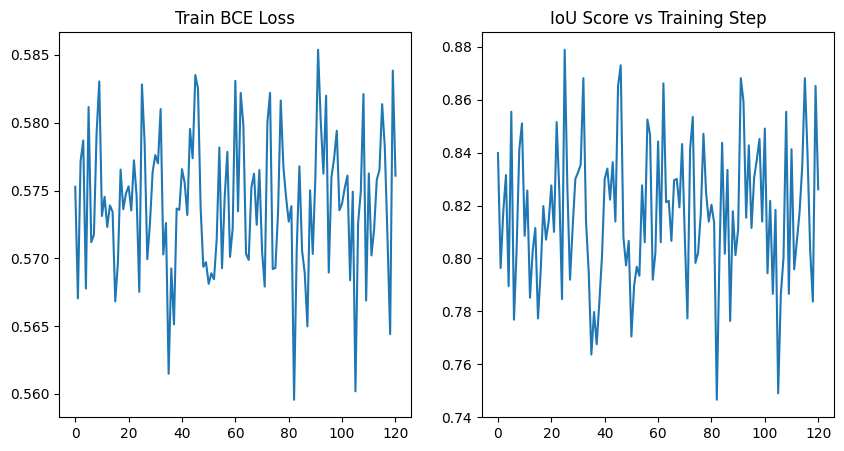

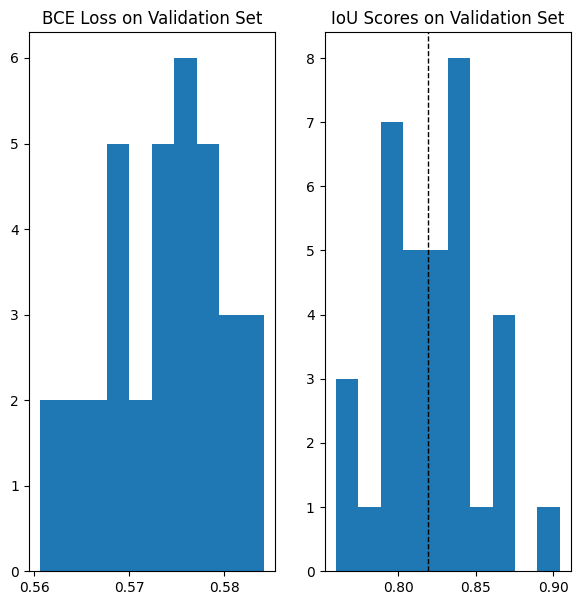

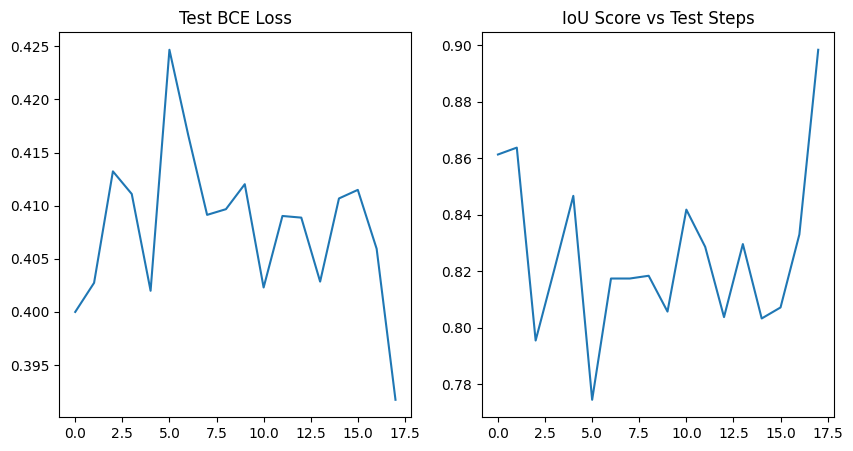

In [42]:
plot_training_scores(results['train_losses'], results['train_scores'])
plot_validation_scores(results['val_losses'], results['val_scores'])
plot_test_scores(test_losses, test_scores)

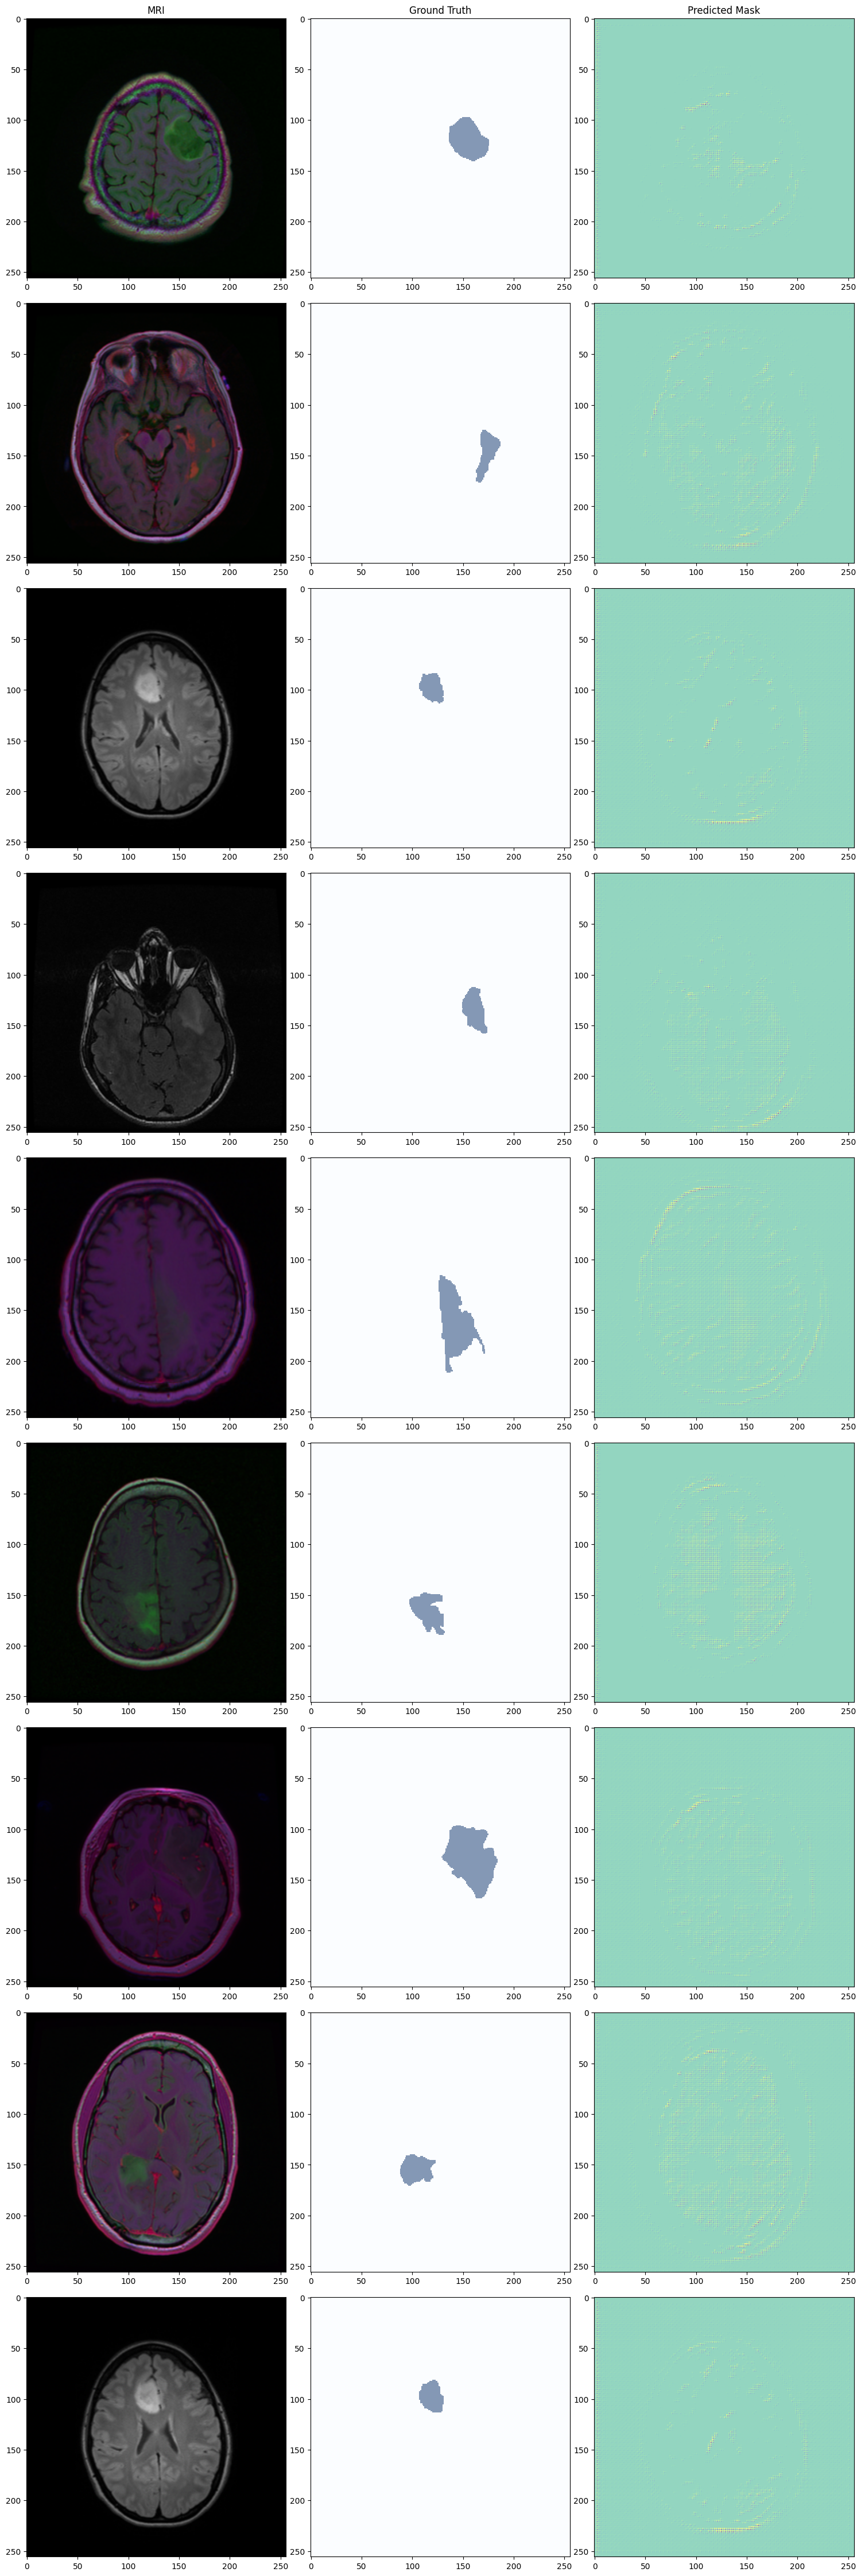

In [47]:
model = modelSegnetQuantum
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn=nn.BCEWithLogitsLoss()

visualize_segmentation(model, test_loader, num_samples=9, device='cpu')
del model
del optimizer
del loss_fn

In [ ]:
#Classical Segnet

In [ ]:
model = modelSegnet
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = dice_loss
train_loader= train_loader
val_loader= val_loader

results = run_experiment("Segnet", model, num_epochs=num_epochs, optimizer=optimizer, loss_fn=loss_fn, train_loader=train_loader, val_loader=val_loader, device='device', clear_mem=True)


In [ ]:
test_losses, test_scores = test_model(model=modelSegnet, test_loader=test_loader, device=device, loss_fn=nn.BCEWithLogitsLoss())


In [ ]:
plot_training_scores(results['train_losses'], results['train_scores'])
plot_validation_scores(results['val_losses'], results['val_scores'])
plot_test_scores(test_losses, test_scores)

In [ ]:
model = modelSegnet
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn=nn.BCEWithLogitsLoss()

visualize_segmentation(model, test_loader, num_samples=10, device='cpu')
del model
del optimizer
del loss_fn


In [ ]:

from openvino.runtime import Core

# Function to load and optimize models using OpenVINO
def load_openvino_model(model_path):
    """Load and optimize an ONNX model using OpenVINO."""
    ie = Core()
    model = ie.read_model(model=model_path)
    compiled_model = ie.compile_model(model=model, device_name="CPU")
    return compiled_model

# Example usage (replace 'model.onnx' with your model path)
# compiled_model = load_openvino_model('model.onnx')
